### Optimizing a scikit model with strange ways

We'll now be trying to maximize some aspect of a specific machine learning model. I've chosen for that to be accuracy.

Requires the Diabetes dataset file from [Kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

Author: Raido Everest

In [1]:
import random
from collections import defaultdict
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
data = pd.read_csv('diabetes.csv')  # Just going to use these like globals. YOLO
X = data.drop('Outcome', axis=1).values
y = data[['Outcome']].values.ravel()

### Common stuff and comments

We've got a few more challenges here, such as discrete variables in the search space, limited range variables in the search space (errors if we'd somehow end up testing zero predictors), and a way more expensive fitness calculation than we're used to (since it is essentially necessary to train and test a model to be able to get it).

I'll try to do some weird kind of discretization in the case of continuous variables to reduce search space a bit - and to possibly make memoization of results feasible. So each numeric feature will have their own min, max, and step sizes. Might actually even work okay.

The parameters of the RF that we'll use are max_depth, ccp_alpha, min_impurity_decrease, so three dimensions in the search space.

PS: Absolutely not as flexible as it might first look - it's still written around just this one model.

In [3]:
# Common to all...
# Ranges takes care of the proper input ranges. If we leave these bounds, we project back.
# Minimum, maximum, 'step size' in decimal points.
ranges = [[2, 20, 0], [0.0, 1.0, 2], [0.0, 0.5, 2]]

# Creates n parameter sets with given ranges for the discussed numbers.
def create_population(n, ranges):
    models = []
    for _ in range(n):
        models.append([gen_param(*dist) for dist in ranges])
    return models

# Generates a random parameter
def gen_param(start, end, decimals):
    rnd = round(random.random() * (end - start) + start, decimals)
    return int(rnd) if decimals == 0 else rnd

# Creates a model based on generated parameters
def create_model(max_depth, ccp_alpha, min_impurity_decrease):
    return RandomForestClassifier(max_depth=max_depth, ccp_alpha=ccp_alpha, min_impurity_decrease=min_impurity_decrease,
                                 random_state=42)

# Updates memory, returns the best new one it found (each method will use same kind of memory)
# This is, of course, an awful name for the function, for its return values aren't really going to be expected
def update_memory(memory, pop):
    best, bestacc = None, 0.0
    for params in pop:
        # If model hasn't been evaluated, evaluate it.
        a,b,c = params
        if memory[a][b][c] == None:
            model = create_model(a,b,c)
            score = cross_val_score(model, X, y, cv=4).mean()
            memory[a][b][c] = score
            if score > bestacc:
                best, bestacc = params, score
    return best, bestacc

# Given some next generation, fix it to be within the limited search space
def fix_generation(pop, ranges):
    for params in pop:
        for i in range(len(params)):
            # Rounds each set of parameters to be within the wanted steps
            params[i] = round(params[i], ranges[i][2])
            # Projects them inside if they are outside the search space
            params[i] = max(params[i], ranges[i][0])  # Raises it to the minimum at least
            params[i] = min(params[i], ranges[i][1])  # Lowers it to the maximum at most

def plot(data, title):
    sns.lineplot(data = data)
    plt.xlabel('Generation')
    plt.ylabel('Best value')
    plt.title(title)
    plt.show()

In [4]:
# Example population of model parameters
create_population(4, ranges)

[[7, 0.6, 0.37], [4, 0.44, 0.5], [13, 0.93, 0.18], [8, 0.11, 0.33]]

In [5]:
# Any of these can be fed into create_model as create_model(*elem).
create_model(*create_population(1, ranges)[0])

RandomForestClassifier(ccp_alpha=0.38, max_depth=19, min_impurity_decrease=0.1,
                       random_state=42)

### Differential Evolution
#### Implementation

In [6]:
# ranges  - ranges for the model parameters
# n       - population size
# scaling - scaling during generating next gen
# loops   - how many loops with no improvement to try
def de(ranges, n=30, scaling=0.5, loops=10):
    # Since some things are discretized now, we may be able to avoid
    # recalculating accuracy by remembering it.
    memory = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None)))

    # Initial model set
    pop = create_population(n, ranges)
    best, bestacc = update_memory(memory, pop)
    history = [bestacc]
    
    # The main loop...
    loops_since_improvement = 0
    while loops_since_improvement < loops:
        loops_since_improvement += 1
        nextpop = de_next(pop, ranges, n, scaling)
        nextbest, nextbestacc = update_memory(memory, nextpop)
        if nextbestacc > bestacc:
            loops_since_improvement = 0
            best, bestacc = nextbest, nextbestacc
        history.append(bestacc)
        # overwrite pop with better ones from nextpop
        de_updatepop(pop, nextpop, memory)

    return best, bestacc, history

# ...
def de_next(pop, ranges, n, scaling):
    nextpop = []
    for i in range(n):
        a, b = random.choice(pop), random.choice(pop)  # Picking two random elements
        nextpop.append([pop[i][j]+scaling*(b[j]-a[j]) for j in range(len(a))])  # Add the scaled ab vector to pop[i]...
        
    fix_generation(nextpop, ranges)  # Solve some problems
    return nextpop

# ...
def de_updatepop(pop, nextpop, memory):
    # Now that everything in pop and nextpop are guaranteed to be in memory,
    # this couldn't be easier.
    for i in range(len(pop)):
        a1,b1,c1 = pop[i]
        a2,b2,c2 = nextpop[i]
        if memory[a2][b2][c2] > memory[a1][b1][c1]:
            pop[i] = nextpop[i]

#### Sanity check

Seems to do okay and get a considered-good accuracy in the end, however the scaling has to be quite high (even above one for best outcome speed wise) for it to really go to a good place (and to be truly performant - by smashing into the corners of some variable range it's a lot more likely to try to compute something we've already computed). Feels strange to do it like this, I'll test it with several configs later.

In [7]:
best, bestval, his = de(ranges, 15, 1.0, 10)
(best, bestval)

([7.0, 0.0, 0.0], 0.7695312500000001)

#### Accuracy graph over time

We find we get the best model VERY early though - in one or two generations it won't move any more. May be because of the chosen parameters, may be the data set.

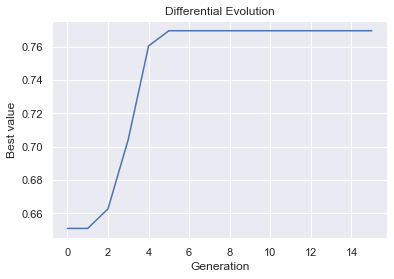

In [8]:
plot(his, "Differential Evolution")

#### Measuring time

So we know we spend most of the time for no reason. So let's measure and contrast the time this method takes with waiting ~3 loops for improvement and ~10 like above to see if we check many models we haven't made yet. (Also freeze the seed because otherwise things may get weird)

In [9]:
random.seed(42)
%timeit -r 1 -n 1 de(ranges, 15, 1.0, 3)

56.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
random.seed(42)
%timeit -r 1 -n 1 de(ranges, 15, 1.0, 10)

1min 21s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Doesn't seem like adding seven extra loops changed runtime so much, suggesting we do get a lot of collisions.

In [11]:
random.seed(42)
%timeit -r 1 -n 1 de(ranges, 15, 3.0, 3)  # Very high scaling - makes big jumps

42.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Bigger jumps seem to have cut down on processing time some.

### Particle Swarm Optimization
#### Implementation

In [12]:
# PSO: still broken as ever.
# ranges  - ranges for the model parameters
# n       - population size
# loops   - how many loops with no improvement to try
# lr      - how much velocity affects future velocity (between 0 and 1)
# c1 and c2   - weighting for personal and overall best when moving  (between 0 and 1)
# res_speed   - the speed we may reset to randomly
# res_speed_p - probability of reset
def pso(ranges, n=15, loops=5, lr=1.0, c1=0.5, c2=0.5, res_speed=5, res_speed_p=0.1):
    # Creating memory in hopes that it helps us catch potential collisions in the discretized search space
    memory = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None)))

    # Initial model set
    pop     = create_population(n, ranges)
    popbest = pop[::]
    velocity      = pso_init_velocities(n)
    best, bestacc = update_memory(memory, pop)
    history = [bestacc]
    
    # The main loop...
    loops_since_improvement = 0
    while loops_since_improvement < loops:
        loops_since_improvement += 1
        
        pso_iterate(ranges, velocity, pop, popbest, best, lr, c1, c2, res_speed, res_speed_p)
        nextbest, nextbestacc = update_memory(memory, pop)
        pso_update_personal_best(memory, pop, popbest)
        if nextbestacc > bestacc:
            loops_since_improvement = 0
            best, bestacc = nextbest, nextbestacc
        history.append(bestacc)

    return best, bestacc, history

# ...
def pso_init_velocities(n):
    choices = list(range(-2,3))
    velocities = []
    for _ in range(n):
        velocities.append([random.choice(choices) for _ in range(3)])
    return velocities

# ...
def normalise(vector, length=1):
    l = np.dot(vector, vector)**0.5
    return [v/l for v in vector]

# ...
# Mutates pop and velocity
def pso_iterate(ranges, velocity, pop, popbest, best, lr, c1, c2, res_speed, res_speed_p):
    for i in range(len(pop)):
        z1, z2 = random.random(), random.random()
        velocity[i] = list(np.add(lr * np.array(velocity[i]),
                                  np.add(c1*z1*np.subtract(popbest[i], pop[i]), c2*z2*np.subtract(best, pop[i]))))
        pop[i] = list(np.add(pop[i], velocity[i]))
        # Reset speed for each particle individually this time around.
        if random.random() < res_speed_p:
            velocity[i] = normalise(velocity[i], res_speed)
    # Now we have to fix up any particles that have left the search space
    fix_generation(pop, ranges)

# ...
# Mutates popbest
def pso_update_personal_best(memory, pop, popbest):
    for i in range(len(pop)):
        a1,b1,c1 = pop[i]
        a2,b2,c2 = popbest[i]
        if memory[a1][b1][c1] > memory[a2][b2][c2]:
            popbest[i] = pop[i]

#### Sanity check

Finds a pretty good solution as well. What really matters now is the speed.

In [13]:
best, bestval, his = pso(ranges)
(best, bestval)

([7.0, 0.0, 0.0], 0.7695312500000001)

#### Accuracy graph over time

Same 'issue' of converging very quickly.

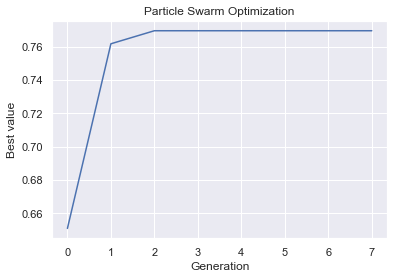

In [14]:
plot(his, "Particle Swarm Optimization")

#### Measuring time

Doesn't seem to be too impressive, even given the kinda low pop we start with. If we cut pop, will it converge quicker?

In [15]:
random.seed(42)
%timeit -r 1 -n 1 pso(ranges)

1min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [16]:
random.seed(42)
%timeit -r 1 -n 1 print(max(pso(ranges, n=10)[2]))

0.7695312500000001
42.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


And we beat DE time with similar end result... What if we go a lot further again?

In [17]:
random.seed(42)
%timeit -r 1 -n 1 print(max(pso(ranges, n=5)[2]))

0.76171875
25.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


It's starting to hurt a tiny bit, but the speed is real. Let's try DE once more, trying to do as little work as possible...

In [18]:
random.seed(42)
%timeit -r 1 -n 1 print(max(de(ranges, 12, 6.0, 3)[2]))  # Super big jumps and smaller pop

0.7604166666666667
24.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Same time for same result. This definitely makes life hard for those of us that just want to call something the best.

### Genetic Algorithm

Finally, it is time for something simple.

#### Implementation

In [19]:
# ranges  - ranges for the model parameters
# n       - population size
# bign    - candidates population size
# loops   - how many loops with no improvement to try
def ga(ranges, n=20, bign=60, loops=5):
    # Creating memory in hopes that it helps us catch potential collisions in the discretized search space
    memory = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None)))

    # Initial model set
    pop     = create_population(n, ranges)
    best, bestacc = update_memory(memory, pop)
    history = [bestacc]
    
    # The main loop...
    loops_since_improvement = 0
    while loops_since_improvement < loops:
        loops_since_improvement += 1
        
        bigpop = ga_nextpop(ranges, pop, bign)
        nextbest, nextbestacc = update_memory(memory, bigpop)
        if nextbestacc > bestacc:
            loops_since_improvement = 0
            best, bestacc = nextbest, nextbestacc
        
        # Sort the models based on their accuracy and take only the best ones.
        pop = sorted(pop + bigpop, key=lambda x: memory[x[0]][x[1]][x[2]], reverse=True)[:n]
        
        history.append(bestacc)

    return best, bestacc, history

# ...
def ga_nextpop(ranges, pop, bign):
    nextpop = []
    for _ in range(bign):
        x1, x2 = random.choice(pop), random.choice(pop)
        nextpop.append(mutate(crossover(x1, x2)))
    fix_generation(nextpop, ranges)  # Solve out of range/legal search space issues
    return nextpop

# ...
def mutate(vector):
    if random.random() < 0.25:
        return vector  # just don't bother with some
    newvector = [elem * (random.random() * 1.5 + 0.5) for elem in vector]
    return newvector

# ...
def crossover(x1, x2):
    return [x1[i] if random.random() < 0.5 else x2[i] for i in range(len(x1))]

#### Sanity check

It kind of gets close but still I notice a difference of nearly a percentage point. DE and PSO found the same results, but GA finds something different...

In [20]:
best, bestval, his = ga(ranges, n=10, bign=15)
(best, bestval)

([3.0, 0.02, 0.02], 0.7539062500000001)

#### Accuracy graph over time

But yeah, still does the same thing. Gets results fast and stays there.

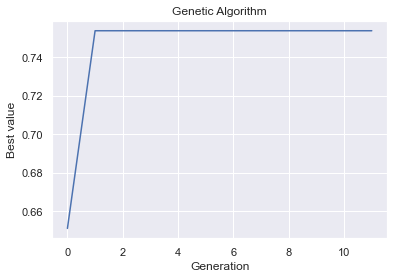

In [21]:
plot(his, "Genetic Algorithm")

#### Measuring time

Long story short, not better for more time.

In [22]:
random.seed(42)
%timeit -r 1 -n 1 ga(ranges, n=10, bign=15)

45.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Let's just run away from GA now.

### Conclusions

Differential evolution and PSO are just doing a great job, at least given this dataset. The generic genetic algorithm unfortunately suffers from performance issues, and in the end finds a result with quite a bad accuracy, I imagine due to the way it ended up going through the search space (it is the only method that gave nonzero float parameters for example and it is kind of biased toward higher values since mutation scales uniformly from 0.5x to 2x).